#Deep Learning in Data Science: **Training a RNN to synthesize English text character by character** 
#Alexander Bea - abea@kth.se
#Assignment 4

*In this assignment I had to train a vanilla RNN with outputs using the text from the book The Globlet of Fire by J.K. Rowling.*

The following implementation will train a recurrent neural network (RNN) that shows how the evolution of the text synthesized by my RNN during training by inclduing a sample of synthesized text (200 characters long) before the first and before every 10,000th update steps when I train for 100,000 update. Furthermore, I also present 1000 characters with the best implementation.

In [0]:
#@title Installers
!pip install texttable

In [0]:
#@title Import libraries
from texttable import Texttable
from collections import OrderedDict
from keras import applications
from keras.models import Sequential
from keras.layers import Flatten
from keras.layers import Input
from keras.models import Model
from keras.layers import Dense
from keras.layers import Dropout
from keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from google.colab import drive
import matplotlib.pyplot as plt
import numpy as np
import random

drive.mount('/content/drive/')

Using TensorFlow backend.


Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [0]:
#@title Functions: Read file from drive
def LoadData():
    data = open("/content/drive/My Drive/The Globlet of Fire by J.K. Rowling/goblet_book.txt", "r", encoding='utf8').read()
    chars = list(set(data))
    data = {"data": data, "chars": chars,
            "vocLen": len(chars), "getIndFromChar": OrderedDict(
                (char, ix) for ix, char in enumerate(chars)),
            "getCharFromInd": OrderedDict((ix, char) for ix, char in
                enumerate(chars))}
    return data

In [0]:
#@title Functions: Initialization
class RecurrentNeuralNetwork():
  def __init__(self, data, m=100, eta=.1, seq_length=25):
      self.m, self.eta, self.N = m, eta, seq_length
      for k, v in data.items():
          setattr(self, k, v)
      self.b, self.c, self.U, self.V, self.W = self._init_parameters(self.m, self.vocLen)

  @staticmethod
  def _init_parameters(m, K, sig=0.01):
      c = np.zeros((K, 1))
      b = np.zeros((m, 1))
      V = np.random.normal(0, sig, size=(K, m))
      W = np.random.normal(0, sig, size=(m, m))
      U = np.random.normal(0, sig, size=(m, K))
      return b, c, U, V, W

In [0]:
#@title Functions: Softmax, EvaluateClassifier
class RNN_With_Functions(RecurrentNeuralNetwork):
    @staticmethod
    def SoftMax(x):
        s = np.exp(x - np.max(x, axis=0)) / np.exp(x - np.max(x, axis=0)).sum(axis=0)
        return s

    def EvaluateClassifier(self, h, x):
        a = self.W@h + self.U@x + self.b
        h = np.tanh(a)
        o = self.V@h + self.c
        p = self.SoftMax(o)
        return a, h, o, p


In [0]:
#@title Functions: Synthesize Text
class RNN_Synthesizer(RNN_With_Functions):
    def SynthesizeText(self, h, aax, n):
        text = ''
        nxt = np.zeros((self.vocLen, 1))
        nxt[aax] = 1 
        for s in range(n):
            _, h, _, p = self.EvaluateClassifier(h, nxt)
            aax = np.random.choice(range(self.vocLen), p=p.flat)
            nxt = np.zeros((self.vocLen, 1))
            nxt[aax] = 1 
            text += self.getCharFromInd[aax]
        return text

The following functions will compute the gradients analytically, numerically and check the gradietns. The difference between the two gradients computation will be iteratively presented when the training is ongoing.

In [0]:
#@title Functions: Compute and Check Gradients
class RNN_Gradients(RNN_Synthesizer):
    def ComputeGradientsAnalytically(self, inputs, targets, hp):
        loss = 0
        aa, bb, cc, dd, ee = {}, {}, {}, {}, {}
        cc[-1] = np.copy(hp)
        nt = len(inputs)
        for t in range(nt):
            bb[t] = np.zeros((self.vocLen, 1))
            bb[t][inputs[t]] = 1 
            aa[t], cc[t], dd[t], ee[t] = self.EvaluateClassifier(cc[t-1], bb[t])
            loss += -np.log(ee[t][targets[t]][0]) 

        gradients = {"W": np.zeros_like(self.W), "U": np.zeros_like(self.U),
                 "V": np.zeros_like(self.V), "b": np.zeros_like(self.b),
                 "c": np.zeros_like(self.c), "o": np.zeros_like(ee[0]),
                 "h": np.zeros_like(cc[0]), "hnxt": np.zeros_like(cc[0]),
                 "a": np.zeros_like(aa[0])}

        for t in reversed(range(nt)):
            gradients["o"] = np.copy(ee[t])
            gradients["o"][targets[t]] -= 1
            gradients["V"] += gradients["o"]@cc[t].T
            gradients["c"] += gradients["o"]
            gradients["h"] = self.V.T@gradients["o"] + gradients["hnxt"]
            gradients["a"] = np.multiply(gradients["h"], (1 - np.square(cc[t])))
            gradients["U"] += gradients["a"]@bb[t].T
            gradients["W"] += gradients["a"]@cc[t-1].T
            gradients["b"] += gradients["a"]
            gradients["hnxt"] = self.W.T@gradients["a"]

        gradients = {k: gradients[k] for k in gradients if k not in ["o", "h", "hnxt", "a"]}
        for gr in gradients: gradients[gr] = np.clip(gradients[gr], -5, 5)
        he = cc[nt-1]
        return gradients, loss, he

    def ComputeGradientsNumerically(self, inputs, targets, hp, h, nc=20):
        network_params = {"W": self.W, "U": self.U, "V": self.V, "b": self.b, "c": self.c}
        num_gradients  = {"W": np.zeros_like(self.W), "U": np.zeros_like(self.U),
                      "V": np.zeros_like(self.V), "b": np.zeros_like(self.b),
                      "c": np.zeros_like(self.c)}

        for key in network_params:
            for i in range(nc):
                prevpar = network_params[key].flat[i] 
                network_params[key].flat[i] = prevpar + h
                _, l1, _ = self.ComputeGradientsAnalytically(inputs, targets, hp)
                network_params[key].flat[i] = prevpar - h
                _, l2, _ = self.ComputeGradientsAnalytically(inputs, targets, hp)
                network_params[key].flat[i] = prevpar 
                num_gradients[key].flat[i] = (l1 - l2) / (2*h)

        return num_gradients


    def CheckGradients(self, inputs, targets, hp, nc=20):
        analytical_gr, _, _ = self.ComputeGradientsAnalytically(inputs, targets, hp)
        numerical_gr = self.ComputeGradientsNumerically(inputs, targets, hp, 1e-5)

        err = Texttable()
        err_data = [] 

        # Compare accurate numerical method with analytical estimation of gradient
        err_data.append(['Gradient', 'Method',  'Abs Diff Mean [e-06]'])

        print("Gradient checks:")
        for grad in analytical_gr:
            num   = abs(analytical_gr[grad].flat[:nc] - numerical_gr[grad].flat[:nc])
            denom = np.asarray([max(abs(a), abs(b)) + 1e-10 for a,b in zip(analytical_gr[grad].flat[:nc],numerical_gr[grad].flat[:nc])])
            err_data.append([grad, "ANL vs NUM", str(max(num / denom)*100*10*100)])

        err.add_rows(err_data)
        print("Method Comparison: Analytical vs Numerical")
        print(err.draw())      


In [0]:
#@title Functions: Check Gradients
def CompareGradients():
  e=0
  data = LoadData()
  network = RNN_Gradients(data)
  hp = np.zeros((network.m, 1))

  inputs = [network.getIndFromChar[char] for char in network.data[e:e+network.N]]
  targets = [network.getIndFromChar[char] for char in network.data[e+1:e+network.N+1]]

  gradients, loss, hp = network.ComputeGradientsAnalytically(inputs, targets, hp)

  # Check gradients
  network.CheckGradients(inputs, targets, hp)


i) The following generates the gradient comparing result (max relative error) that shows that the implemented analytical gradient method is close enough to be regarded as accurate. Within this check, a state sequence of zeros was used as well as hyperparameters of m=100 (hidden state dimensionality) and eta=.1 (learning rate), seq_length=25 and sig=.01. Important to note is that I only check the first initial entries of the gradient matrices for the following resulting max relative errors.

In [0]:
CompareGradients()

Gradient checks:
Method Comparison: Analytical vs Numerical
+----------+------------+----------------------+
| Gradient |   Method   | Abs Diff Mean [e-06] |
+==========+============+======================+
| W        | ANL vs NUM | 1.188                |
+----------+------------+----------------------+
| U        | ANL vs NUM | 0.059                |
+----------+------------+----------------------+
| V        | ANL vs NUM | 0.108                |
+----------+------------+----------------------+
| b        | ANL vs NUM | 0.010                |
+----------+------------+----------------------+
| c        | ANL vs NUM | 0.001                |
+----------+------------+----------------------+


In [0]:
#@title Functions: Run Training
losses = []
def RunTraining():
    num_epochs = 9 #ändra till 3 när jag kört för bästa sen
    e, n, epoch = 0, 0, 0
    data = LoadData()
    network = RNN_Gradients(data) 
    network_params = {"W": network.W, "U": network.U, "V": network.V, "b": network.b, "c": network.c}
    params = {"W": np.zeros_like(network.W), "U": np.zeros_like(network.U), "V": np.zeros_like(network.V), "b": np.zeros_like(network.b),"c": np.zeros_like(network.c)}

    while epoch <= num_epochs and n <= 600000: #ändra till 100,000 när denna är klar
        if n == 0 or e >= (len(network.data) - network.N - 1):
            hp = np.zeros((network.m, 1))
            epoch += 1
            e = 0

        inputs = [network.getIndFromChar[char] for char in network.data[e:e+network.N]]
        targets = [network.getIndFromChar[char] for char in network.data[e+1:e+network.N+1]]
        gradients, loss, hp = network.ComputeGradientsAnalytically(inputs, targets, hp)

        if n == 0 and epoch == 1: smoothloss = loss
        smoothloss = 0.999 * smoothloss + 0.001 * loss

        if n % 10000 == 0:
            text = network.SynthesizeText(hp, inputs[0], 200)
            print('\nIterations %i, smooth loss: %f \n %s\n' % (n, smoothloss, text))

        for k in network_params:
            params[k] += gradients[k] * gradients[k]
            network_params[k] -= network.eta / np.sqrt(params[k] + np.finfo(float).eps) * gradients[k]

        e += network.N
        n += 1
        losses.append(smoothloss)     

    text = network.SynthesizeText(hp, inputs[0], 1000)

    print('\nBest performance')
    print('\n %s\n' % (text))   

iii) Next follows the 200 characters of synthesized text before the first and before every 10,000th update steps when I train for 100,000 update steps. Smooth loss is also displayed

iv) Best performance of 1000 characters is also presented (390,000 iterations)

In [0]:
RunTraining()


Iterations 0, smooth loss: 109.549578 
 vwcob1k7j)Z9CAgHKüt}/)MAGiUmC(ZBxDziJ,I:G,PY4v)V6gXucE2MRX20f
,"PL4Ywyyvo^I2DuPE•w,9x;TlIo(GUq/gHüa I,szAAma:EWLL:IQ.Y7:;	MV0qe2üy6K3pW0xmm? ktdaNJKOwv7ESIA}N.g(FOqFk^KAt9/-yKCnlOiz,ü	yHl6kcMgoX6AePDG


Iterations 10000, smooth loss: 56.221798 
 ole. .  Bed harcutea walls thand rey'a sidess cust,"
Pailping hes rtromitheighery as'singe," the diand innted to bul gh "I sulled ase he the foachey ingom out  ojbaen ladminglait Hardoud witistithith 


Iterations 20000, smooth loss: 52.583628 
 ed hay; carkigt late at shes wemped. us -I. buirgaryee tho undo wes's of ton the aling must haflid Fput.  Sbike in "or cark whinf ouss hagry, roimptod do anming were Cutca oble corciens shough ap sate


Iterations 30000, smooth loss: 51.172260 
 egrer.
"Wla't nows goft as yough hou thicoutsed oreboning here, . .  This's youg, anrtey?
"Yougit, eatpeder. ... . ... narr, wers thitodid and Cawled dagmsto bagh stich a barkes quast eadbyeperols ack


Iterations 40000, 

ii) A graph of the smooth loss function for a longish training run (3 epochs)

In [0]:
#@title Functions: Smooth Loos Plot
def plot():
    loss_plot = plt.plot(losses, label="training loss")
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend()
    plt.show() 

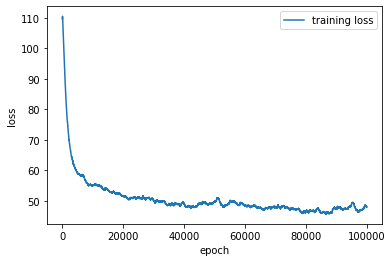

In [0]:
plot()